# NLP Data Exploration

## Exercises

Do your work for this exercise in a file named explore.

### Imports

In [1]:
import re
import unicodedata
import pandas as pd
import nltk #natural language tool kit
from wordcloud import WordCloud

from env import user, password, host

### 1. Spam Data
- Load the spam data set.
- Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?
- Is there any overlap in the bigrams for the spam data and the ham data?
- Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

#### Acquire

In [2]:
#load spam data set
def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### Prepare

In [3]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt'] #ltgt is html artifact

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

#### Explore

In [4]:
#percentage of hams vs spams
df.label.value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: label, dtype: float64

In [5]:
#concatenate two diff value counts together
#count on the left, percent on the right
labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [6]:
#show counts and ratios
def show_counts_and_ratios(df, column):
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    
    return labels


show_counts_and_ratios(df, 'label')

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [7]:
#treat the series like a list
#calling clean function and joining everything together
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))

In [8]:
#value counts on each one of these
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()
#most frequent spam words

In [9]:
#taking in three diff df will give you one df
#adding left to right
#stitching and sorting
#adding column headers
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int))) #superfluous

word_counts.tail()

,all,ham,spam
zoe,2,1,1
zogtorius,1,1,0
zoom,1,1,0
zouk,1,0,1
zyada,1,1,0


In [10]:
#sort by most frequent
#call looks to be evenly distributed by ham and spam
#spam has the word call in it alot
word_counts.sort_values(by='all', ascending=False).head(10)

,all,ham,spam
call,600,241,359
im,462,449,13
get,397,314,83
ur,384,240,144
go,304,273,31
4,287,168,119
dont,279,257,22
ok,277,272,5
free,275,59,216
know,267,241,26


In [11]:
#concatenate them all together
pd.concat([word_counts[word_counts.spam == 0].sort_values(by='ham').tail(6),
           word_counts[word_counts.ham == 0].sort_values(by='spam').tail(6)])

,all,ham,spam
thats,94,94,0
i_,117,117,0
say,118,118,0
da,132,132,0
later,134,134,0
lor,160,160,0
awarded,38,0,38
18,43,0,43
guaranteed,50,0,50
tone,73,0,73


In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Proportion of Spam vs Ham for the 20 most common words')

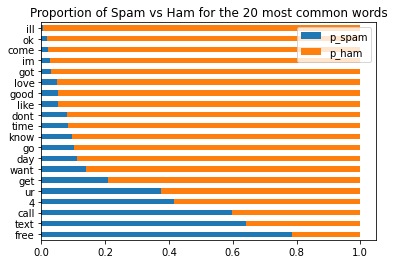

In [13]:
# figure out the percentage of spam vs ham
#taking word counts and making percentages with .assign
#sorting by all words
#labeling labels
(word_counts
 .assign(p_spam=word_counts.spam / word_counts['all'],
         p_ham=word_counts.ham / word_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')

In [14]:
#bigram out of ham words
#turn into series
#then do value counts on that series
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                      .value_counts()
                      .head(20))

top_20_ham_bigrams.head()

(call, later)    52
(ill, call)      48
(let, know)      42
(sorry, ill)     39
(dont, know)     32
dtype: int64

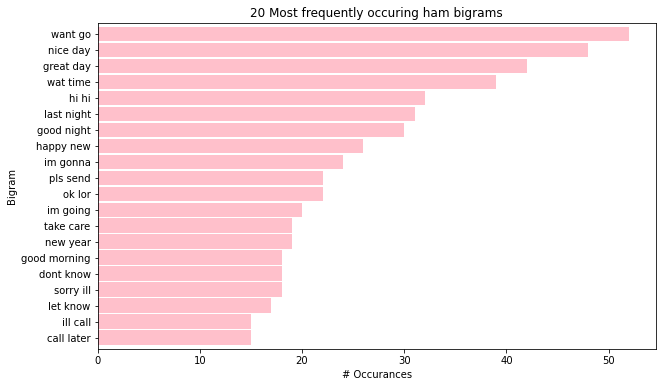

In [15]:
#horizontal bar chart to show value counts of top 20 hambigrams
top_20_ham_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1]) #handling concatenating tuples together, cant actully set an index with a tuple, apply function contatenates tuple
_ = plt.yticks(ticks, labels)

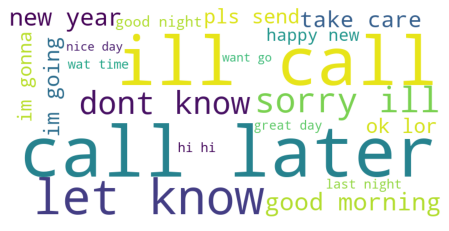

In [16]:
#ham word cloud

data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [17]:
#bigram out of spam words
#turn into series
#then do value counts on that series
top_20_spam_bigrams = (pd.Series(nltk.ngrams(spam_words, 2))
                      .value_counts()
                      .head(20))

top_20_spam_bigrams.head()

(please, call)         44
(customer, service)    27
(po, box)              24
(guaranteed, call)     23
(a1000, cash)          23
dtype: int64

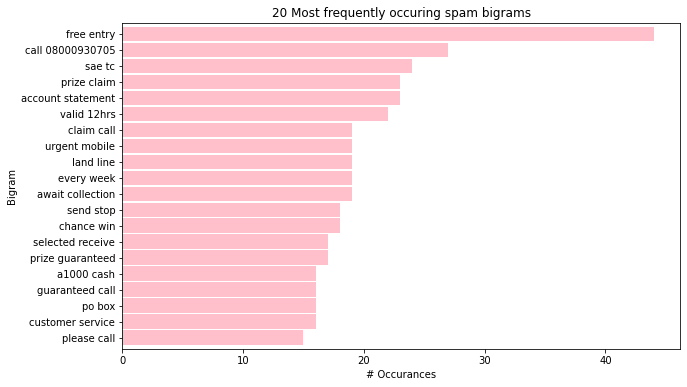

In [18]:
#horizontal bar chart to show value counts of top 20 spambigrams
top_20_spam_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring spam bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_spam_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1]) #handling concatenating tuples together, cant actully set an index with a tuple, apply function contatenates tuple
_ = plt.yticks(ticks, labels)

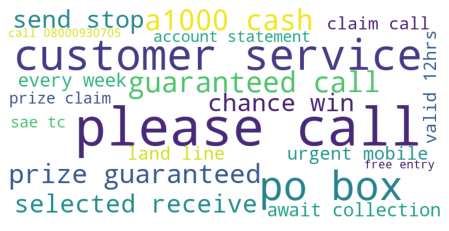

In [19]:
#spam word cloud
data = {k[0] + ' ' + k[1]: v for k, v in top_20_spam_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

### 2. Explore the blog articles using the techniques discussed in the exploration lesson.

### 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.

- compare sports vs business